In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
!pip install kaggle -q
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions
!unzip -q flickr8kimagescaptions.zip

 99% 1.03G/1.04G [00:12<00:00, 101MB/s] 
100% 1.04G/1.04G [00:12<00:00, 90.3MB/s]


In [4]:
# get the code form github
!git clone https://github.com/moaaztaha/Image-Captioning
py_files_path = 'Image-Captioning/'
import sys
sys.path.append(py_files_path)

Cloning into 'Image-Captioning'...
remote: Enumerating objects: 637, done.
remote: Counting objects: 100% (637/637), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 637 (delta 384), reused 567 (delta 314), pack-reused 0
Receiving objects: 100% (637/637), 39.39 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (384/384), done.
Checking out files: 100% (118/118), done.


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from dataset import build_vocab
from utils import *
from models import *

import sys

def caption_image(img_path, beam_size=3):
    
    # transforms
    tt = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])


    # english
    # vocab = build_vocab('data.json')
    # checkpoint = load_checkpoint('E:\GP\Image-Captioning\models\BEST_checkpoint_flickr8k_finetune.pth.tar', cpu=True)

    # arabic
    vocab = build_vocab('/content/Image-Captioning/data.json')
    checkpoint = load_checkpoint('/content/drive/MyDrive/ImageCaptioning/flickr8/BEST_checkpoint_flickr8k_finetune.pth.tar', cpu=True)


    addit_tokens = [vocab.stoi['<sos>'], vocab.stoi['<eos>'], vocab.stoi['<pad>']]
    device = torch.device( 'cpu')


    encoder = checkpoint['encoder'].to(device)
    decoder = checkpoint['decoder'].to(device)

    #def cap_image(encoder, decoder, image_path, vocab):
    vocab_size = len(vocab)


    img = Image.open(img_path).convert("RGB")
    img = tt(img).unsqueeze(0) # transform and batch
    image = img.to(device)

    #encoder
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)



    k = beam_size 
    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[vocab.stoi['<sos>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)
        
        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)
#         print(seqs[prev_word_inds], prev_word_inds)
#         if step == 5:
#             return seqs
        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != vocab.stoi['<eos>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    print(complete_seqs_scores)
    # print(seq)
    all_caps = [" ".join([vocab.itos[i] for i in sent if i not in addit_tokens]) for sent in complete_seqs]
    all_b_caps = ""
    z = 1
    for cap in all_caps:
        all_b_caps += str(z) + ". " + cap + " || <br> "
        z += 1
    # all_b_caps = [" || ".join(all_caps)][0]


    # return seq, alphas, complete_seqs, i
    # return [" ".join([vocab.itos[i] for i in seq if i not in addit_tokens])][0]
    # return all_b_caps
    return alphas, seq, all_caps

In [ ]:
alphas, seq, all_caps = caption_image("/content/Image-Captioning/test_examples/dog.jpg")

100%|██████████| 40000/40000 [00:00<00:00, 263183.16it/s]


Loaded Checkpoint!!
Last Epoch: 12
Best Bleu-4: 15.97917426288958
[tensor(-6.6534, grad_fn=<UnbindBackward>), tensor(-7.0904, grad_fn=<UnbindBackward>), tensor(-7.2692, grad_fn=<UnbindBackward>)]


In [6]:
import skimage.transform
import matplotlib.cm as cm

def visualize_att(image_path, seq, alphas, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    vocab = build_vocab('/content/Image-Captioning/data.json')
    addit_tokens = [vocab.stoi['<sos>'], vocab.stoi['<eos>'], vocab.stoi['<pad>']]
    
    words = [vocab.itos[i] for i in seq if i not in addit_tokens]

    plt.figure(figsize=(16, 8)) 
    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha, [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.6)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

100%|██████████| 40000/40000 [00:00<00:00, 231322.45it/s]


Loaded Checkpoint!!
Last Epoch: 12
Best Bleu-4: 15.97917426288958
[tensor(-8.0566, grad_fn=<UnbindBackward>), tensor(-9.0138, grad_fn=<UnbindBackward>), tensor(-11.4328, grad_fn=<UnbindBackward>)]
['a group of people are walking together', 'a group of people are standing in the street', 'a group of people are standing in front of a street']


100%|██████████| 40000/40000 [00:00<00:00, 242811.99it/s]


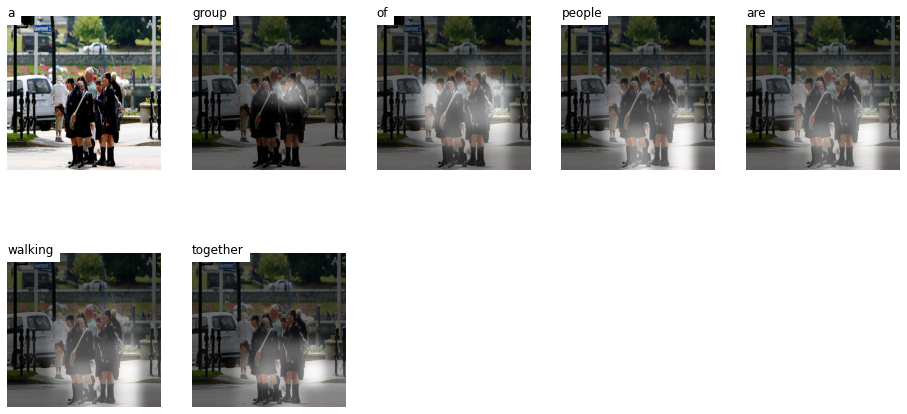

In [ ]:
img = "/content/flickr8k/images/2532262109_87429a2cae.jpg"
alphas, seq, all_caps = caption_image(img)
print(all_caps)
visualize_att(img, seq, alphas)

100%|██████████| 40000/40000 [00:00<00:00, 236669.49it/s]


Loaded Checkpoint!!
Last Epoch: 12
Best Bleu-4: 15.97917426288958


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


[tensor(-9.9173, grad_fn=<UnbindBackward>), tensor(-13.4978, grad_fn=<UnbindBackward>), tensor(-17.9916, grad_fn=<UnbindBackward>)]
['a boy in a blue shirt is standing in the grass', 'a boy in a blue shirt is playing with a toy in a yard', 'a boy in a blue shirt is standing in the grass with a toy in a yard']


100%|██████████| 40000/40000 [00:00<00:00, 220013.77it/s]


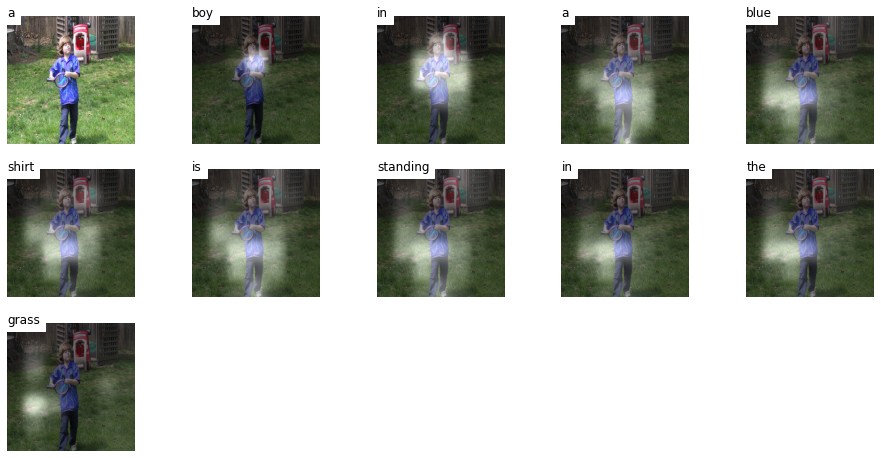

In [7]:
img = "/content/flickr8k/images/3465606652_f380a38050.jpg"
alphas, seq, all_caps = caption_image(img)
print(all_caps)
visualize_att(img, seq, alphas)

100%|██████████| 40000/40000 [00:00<00:00, 249722.64it/s]


Loaded Checkpoint!!
Last Epoch: 12
Best Bleu-4: 15.97917426288958
[tensor(-6.3430, grad_fn=<UnbindBackward>), tensor(-7.0890, grad_fn=<UnbindBackward>), tensor(-7.1286, grad_fn=<UnbindBackward>)]
['a skier skiing down a snowy mountain', 'a skier is skiing down a snowy mountain', 'a man is skiing down a snowy mountain']


100%|██████████| 40000/40000 [00:00<00:00, 235067.53it/s]


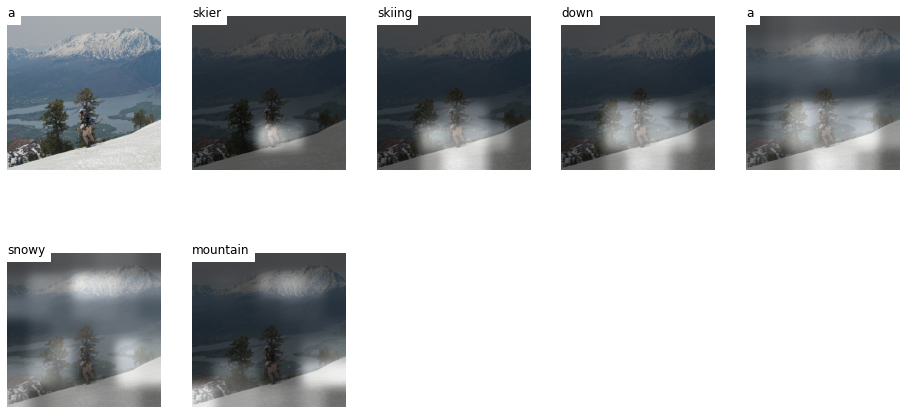

In [9]:
img = "/content/flickr8k/images/3549997413_01388dece0.jpg"
alphas, seq, all_caps = caption_image(img)
print(all_caps)
visualize_att(img, seq, alphas)

100%|██████████| 40000/40000 [00:00<00:00, 246129.43it/s]


Loaded Checkpoint!!
Last Epoch: 12
Best Bleu-4: 15.97917426288958
[tensor(-10.3377, grad_fn=<UnbindBackward>), tensor(-10.3963, grad_fn=<UnbindBackward>), tensor(-12.5531, grad_fn=<UnbindBackward>)]
['a group of people are standing on a street', 'a group of people are standing on a sidewalk', 'a group of people are standing in front of a crowd']


100%|██████████| 40000/40000 [00:00<00:00, 250751.27it/s]


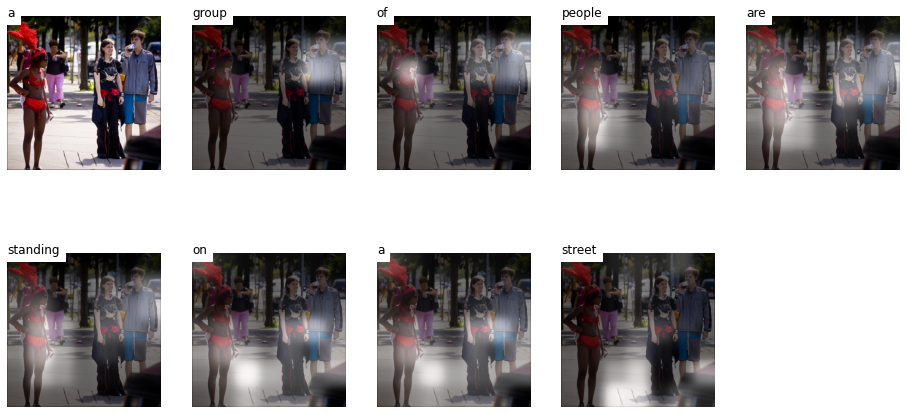

In [12]:
img = "/content/flickr8k/images/1088767354_2acee738cf.jpg"
alphas, seq, all_caps = caption_image(img)
print(all_caps)
visualize_att(img, seq, alphas)

100%|██████████| 40000/40000 [00:00<00:00, 227092.61it/s]


Loaded Checkpoint!!
Last Epoch: 12
Best Bleu-4: 15.97917426288958
[tensor(-8.2463, grad_fn=<UnbindBackward>), tensor(-8.8708, grad_fn=<UnbindBackward>), tensor(-13.1399, grad_fn=<UnbindBackward>)]
['a person rides a bike in the woods', 'a person rides a bike in a forest', 'a man in a blue shirt is riding a bike in the woods']


100%|██████████| 40000/40000 [00:00<00:00, 247487.70it/s]


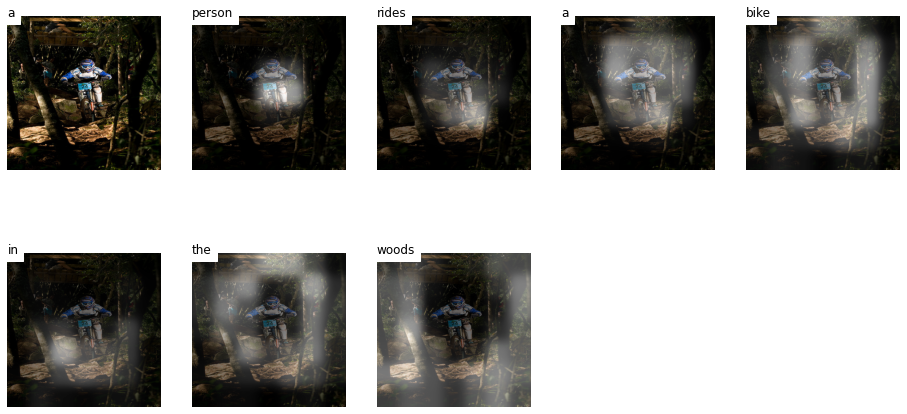

In [15]:
img = "/content/flickr8k/images/3263395801_5e4cee2b9e.jpg"
alphas, seq, all_caps = caption_image(img)
print(all_caps)
visualize_att(img, seq, alphas)